# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp
import plot 
LIKELIHOOD_MODEL = 'likelihood-v1'
PREDICTION_MODEL = 'predict-v1'
sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
route_n = 3 # all data used currently is from route 3
n_segs = data.seg.unique()
data.head()

def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(latlon, axis=1)
    return synched_data
  

## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [2]:

def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_data(synch_gp, seg)
    n_restarts = 5
    
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg, 
        ['tau'],
        ['lat', 'lon'],
        LIKELIHOOD_MODEL,
        route_n, 
        traj_n, 
        seg_n)
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg, 
        ['tau'], 
        ['time_left'], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    gp.train(prediction_model, n_restarts)
    return likelihood_model, prediction_model

def train_traj_segs(traj, traj_n):
    n_segs = traj.seg.unique()
    return {seg_n: train_seg_gps(traj[traj.seg == seg_n], route_n, traj_n, seg_n) for seg_n in n_segs}
          
n_trajs = data.traj.unique()
t0 = time.time()
traj_gps = {traj_n: train_traj_segs(data[data.traj == traj_n], traj_n) for traj_n in n_trajs}
dt = time.time() - t0
print("Data processed in", dt, " seconds")

Optimization restart 1/5, f = -543.471154394161
Optimization restart 2/5, f = -543.4711557995754
Optimization restart 3/5, f = -543.4711210641872
Optimization restart 4/5, f = -543.4711623636902
Optimization restart 5/5, f = -543.4711758330527
Optimization restart 1/5, f = 94.85642306205362
Optimization restart 2/5, f = 94.8564230620126
Optimization restart 3/5, f = 94.85642306253482
Optimization restart 4/5, f = 94.85642306297176
Optimization restart 5/5, f = 94.85642306398097
Optimization restart 1/5, f = -590.3238729641773
Optimization restart 2/5, f = -590.3235479487264
Optimization restart 3/5, f = -590.3238114043213
Optimization restart 4/5, f = -590.3238654670306
Optimization restart 5/5, f = -590.3237832656504
Optimization restart 1/5, f = -18.049967204100234
Optimization restart 2/5, f = -18.04996720444712
Optimization restart 3/5, f = -18.049967204287817
Optimization restart 4/5, f = -18.049967204162137
Optimization restart 5/5, f = -18.049967201579513
Optimization restart 1/

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 107.36051984063045
Optimization restart 4/5, f = 107.3605198440577
Optimization restart 5/5, f = 107.36051984061893
Optimization restart 1/5, f = -726.270328202485
Optimization restart 2/5, f = -726.2705718178468
Optimization restart 3/5, f = -726.2703998385125
Optimization restart 4/5, f = -726.2704096611303
Optimization restart 5/5, f = -726.2703616614094
Optimization restart 1/5, f = 96.81458910195369
Optimization restart 2/5, f = 97.73358308928329
Optimization restart 3/5, f = 97.7335830833124
Optimization restart 4/5, f = 97.73358308385703
Optimization restart 5/5, f = 97.73358309375492
Optimization restart 1/5, f = -462.59839869958955
Optimization restart 2/5, f = -462.5984575006936
Optimization restart 3/5, f = -462.59842741724697
Optimization restart 4/5, f = -462.5984633798853
Optimization restart 5/5, f = -462.59850196054697
Optimization restart 1/5, f = 83.84602210644672
Optimization restart 2/5, f = 83.84602210646098
Optimization restart 3/5, f

Optimization restart 3/5, f = 184.83367435345792
Optimization restart 4/5, f = 184.8336743534415
Optimization restart 5/5, f = 183.39072846176848
Optimization restart 1/5, f = -725.5564623974223
Optimization restart 2/5, f = -725.5563656078292
Optimization restart 3/5, f = -725.5564179197056
Optimization restart 4/5, f = -725.5564209681669
Optimization restart 5/5, f = -725.5564428949805
Optimization restart 1/5, f = 103.45614918952698
Optimization restart 2/5, f = 103.45614918952697
Optimization restart 3/5, f = 103.45614918961658
Optimization restart 4/5, f = 103.45614919136014
Optimization restart 5/5, f = 105.20873417625322
Optimization restart 1/5, f = -728.6215304106272
Optimization restart 2/5, f = -726.9118968978678
Optimization restart 3/5, f = -728.6216288289324
Optimization restart 4/5, f = -728.6212892907599
Optimization restart 5/5, f = -710.300991884623
Optimization restart 1/5, f = 86.04807213169154
Optimization restart 2/5, f = 86.0480721273688
Optimization restart 3/5,

Optimization restart 2/5, f = 104.13917864845708
Optimization restart 3/5, f = 105.59359266328326
Optimization restart 4/5, f = 105.59359266328445
Optimization restart 5/5, f = 104.13917864847375
Optimization restart 1/5, f = -823.55247030216
Optimization restart 2/5, f = -814.0201429709853
Optimization restart 3/5, f = -814.0200838385432
Optimization restart 4/5, f = -814.0201622089093
Optimization restart 5/5, f = -814.0201048602135
Optimization restart 1/5, f = 124.99687516465849
Optimization restart 2/5, f = 135.39899803444456
Optimization restart 3/5, f = 124.99687510509487
Optimization restart 4/5, f = 124.99687510927579
Optimization restart 5/5, f = 135.3989980341912
Optimization restart 1/5, f = -527.4825393040924
Optimization restart 2/5, f = -527.4825368009714
Optimization restart 3/5, f = -527.4825259173764
Optimization restart 4/5, f = -527.4825461735029
Optimization restart 5/5, f = -527.4825088343257
Optimization restart 1/5, f = 89.78597927566396
Optimization restart 2/5

Optimization restart 5/5, f = 103.10243261243761
Optimization restart 1/5, f = -446.05603681671596
Optimization restart 2/5, f = -446.05606637917316
Optimization restart 3/5, f = -446.0560469643741
Optimization restart 4/5, f = -446.0560031297797
Optimization restart 5/5, f = -446.05605898161497
Optimization restart 1/5, f = 66.83750403866338
Optimization restart 2/5, f = 66.83750403830891
Optimization restart 3/5, f = 66.83750404415493
Optimization restart 4/5, f = 66.83750403854349
Optimization restart 5/5, f = 66.83750403832465
Optimization restart 1/5, f = -692.8751684305389
Optimization restart 2/5, f = -692.875488898459
Optimization restart 3/5, f = -692.8751942760327
Optimization restart 4/5, f = -692.8753228175544
Optimization restart 5/5, f = -692.875356810639
Optimization restart 1/5, f = 52.79751756742622
Optimization restart 2/5, f = 52.797517567124416
Optimization restart 3/5, f = 52.79751756674308
Optimization restart 4/5, f = 52.79751756684284
Optimization restart 5/5, f

Optimization restart 2/5, f = -584.1056322956455
Optimization restart 3/5, f = -584.1056060542933
Optimization restart 4/5, f = -584.105520909749
Optimization restart 5/5, f = -584.1056286469797
Optimization restart 1/5, f = 119.24088730357506
Optimization restart 2/5, f = 119.24088730353066
Optimization restart 3/5, f = 119.24088730334016
Optimization restart 4/5, f = 119.24088730336034
Optimization restart 5/5, f = 119.24088730466823
Optimization restart 1/5, f = -560.3936013955432
Optimization restart 2/5, f = -560.3936369574576
Optimization restart 3/5, f = -560.3936856152875
Optimization restart 4/5, f = -560.3936341794105
Optimization restart 5/5, f = -560.393630510102
Optimization restart 1/5, f = 143.40244908811476
Optimization restart 2/5, f = 143.40244907273868
Optimization restart 3/5, f = 143.402449191974
Optimization restart 4/5, f = 143.40244907259344
Optimization restart 5/5, f = 143.402449072962
Optimization restart 1/5, f = -661.2704581396584
Optimization restart 2/5, 

Optimization restart 1/5, f = -429.20761552478666
Optimization restart 2/5, f = -429.20760678549635
Optimization restart 3/5, f = -429.2075910907673
Optimization restart 4/5, f = -429.20760436396654
Optimization restart 5/5, f = -429.20760966207524
Optimization restart 1/5, f = 65.47326621570183
Optimization restart 2/5, f = 65.47326621597848
Optimization restart 3/5, f = 65.47326625851167
Optimization restart 4/5, f = 65.47326621593774
Optimization restart 5/5, f = 65.47326621860832
Optimization restart 1/5, f = -1533.725219610571
Optimization restart 2/5, f = -1663.9357142848787
Optimization restart 3/5, f = -1503.1712060217535


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1561.2300175846192
Optimization restart 5/5, f = -1503.1711778546542
Optimization restart 1/5, f = 217.8138452904527
Optimization restart 2/5, f = 241.12571476408542
Optimization restart 3/5, f = 272.87333520277247
Optimization restart 4/5, f = 272.873335202034
Optimization restart 5/5, f = 272.8733352020386
Optimization restart 1/5, f = -676.7973531463421
Optimization restart 2/5, f = -676.7973811340468
Optimization restart 3/5, f = -676.7973200319676
Optimization restart 4/5, f = -676.7973591654653
Optimization restart 5/5, f = -676.7973431110809
Optimization restart 1/5, f = 70.22181053724444
Optimization restart 2/5, f = 70.22181053773758
Optimization restart 3/5, f = 70.22181053725211
Optimization restart 4/5, f = 70.22181055058434
Optimization restart 5/5, f = 70.22181067896362
Optimization restart 1/5, f = -683.7446198726616
Optimization restart 2/5, f = -683.7440544791705
Optimization restart 3/5, f = -683.7444414375975
Optimization restart 4/5, f

Optimization restart 2/5, f = 122.02806979604442
Optimization restart 3/5, f = 122.02806979601559
Optimization restart 4/5, f = 122.02806981993623
Optimization restart 5/5, f = 122.02806979595263
Optimization restart 1/5, f = -828.7501880126949
Optimization restart 2/5, f = -828.7502549773
Optimization restart 3/5, f = -828.7507926667017
Optimization restart 4/5, f = -828.7504409754865
Optimization restart 5/5, f = -828.7501783433429
Optimization restart 1/5, f = 142.2207617688661
Optimization restart 2/5, f = 142.22076176681378
Optimization restart 3/5, f = 142.3345223032628
Optimization restart 4/5, f = 142.3345222986924
Optimization restart 5/5, f = 142.22076184678423
Optimization restart 1/5, f = -511.05775307465933
Optimization restart 2/5, f = -511.05768800582234
Optimization restart 3/5, f = -511.05772092994346
Optimization restart 4/5, f = -511.0577407625765
Optimization restart 5/5, f = -511.0577433702995
Optimization restart 1/5, f = 81.74383122641878
Optimization restart 2/5

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1569.648179196217
Optimization restart 5/5, f = -1370.2955974577278
Optimization restart 1/5, f = 275.1684081605011
Optimization restart 2/5, f = 275.16840815940833
Optimization restart 3/5, f = 275.16840816316613
Optimization restart 4/5, f = 275.16840816727074
Optimization restart 5/5, f = 275.16840840261824
Optimization restart 1/5, f = -626.494660937482
Optimization restart 2/5, f = -626.4946408130021
Optimization restart 3/5, f = -626.4946991175926
Optimization restart 4/5, f = -626.4946756496516
Optimization restart 5/5, f = -626.4946549550175
Optimization restart 1/5, f = 34.41180155873492
Optimization restart 2/5, f = 34.411801559656745
Optimization restart 3/5, f = 34.41180155689818
Optimization restart 4/5, f = 34.41180156232427
Optimization restart 5/5, f = 34.41180155827172
Optimization restart 1/5, f = -682.4897273789577
Optimization restart 2/5, f = -682.4897901557774
Optimization restart 3/5, f = -682.4893467082734
Optimization restart 4/5,

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 89.46867145722945
Optimization restart 3/5, f = 89.46867145650442
Optimization restart 4/5, f = 89.46867145631245
Optimization restart 5/5, f = 89.46867145629946
Optimization restart 1/5, f = -617.5738512487337
Optimization restart 2/5, f = -617.5737017194431
Optimization restart 3/5, f = -617.5737864245754
Optimization restart 4/5, f = -617.5738798293781
Optimization restart 5/5, f = -617.5738270376951
Optimization restart 1/5, f = 102.02071869783762
Optimization restart 2/5, f = 102.02071869925649
Optimization restart 3/5, f = 102.02071869781909
Optimization restart 4/5, f = 102.02071869782364
Optimization restart 5/5, f = 102.02071869781892
Optimization restart 1/5, f = -577.0506322543421
Optimization restart 2/5, f = -577.050535366015
Optimization restart 3/5, f = -577.050585762112
Optimization restart 4/5, f = -577.0505308628408
Optimization restart 5/5, f = -577.0506142989881
Optimization restart 1/5, f = 102.87750647968674
Optimization restart 2/5, 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 101.10314621112647
Optimization restart 5/5, f = 100.24810352284425
Optimization restart 1/5, f = -613.8042929864644
Optimization restart 2/5, f = -613.804298373177
Optimization restart 3/5, f = -613.8043269531235
Optimization restart 4/5, f = -613.8043342694929
Optimization restart 5/5, f = -613.8041185589118
Optimization restart 1/5, f = 71.7964478534754
Optimization restart 2/5, f = 71.79644785090983
Optimization restart 3/5, f = 71.79644785379269
Optimization restart 4/5, f = 71.79644784845888
Optimization restart 5/5, f = 71.79644785932001
Optimization restart 1/5, f = -413.4944379516157
Optimization restart 2/5, f = -413.4943875395384
Optimization restart 3/5, f = -413.494392389856
Optimization restart 4/5, f = -413.4943723686345
Optimization restart 5/5, f = -413.49441375246374
Optimization restart 1/5, f = 75.42188881671845
Optimization restart 2/5, f = 75.42188881671824
Optimization restart 3/5, f = 75.42188882328422
Optimization restart 4/5, f = 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 49.632893701111115
Optimization restart 1/5, f = -614.4844416546875
Optimization restart 2/5, f = -614.4842015438076
Optimization restart 3/5, f = -614.484485757348
Optimization restart 4/5, f = -614.4842298561368
Optimization restart 5/5, f = -614.4844703865408
Optimization restart 1/5, f = 65.3108192342126
Optimization restart 2/5, f = 65.31081923538395
Optimization restart 3/5, f = 65.31081923422265
Optimization restart 4/5, f = 65.31081923419929
Optimization restart 5/5, f = 65.31081923550101
Optimization restart 1/5, f = -511.1380344530347
Optimization restart 2/5, f = -511.1379851899569
Optimization restart 3/5, f = -511.1379788045575
Optimization restart 4/5, f = -511.1379914317366
Optimization restart 5/5, f = -511.1379600064779
Optimization restart 1/5, f = 98.51311983887814
Optimization restart 2/5, f = 98.51311983840161
Optimization restart 3/5, f = 98.51311984048263
Optimization restart 4/5, f = 98.51311983874821
Optimization restart 5/5, f = 9

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -1330.4729152588377
Optimization restart 1/5, f = 241.80204121317797
Optimization restart 2/5, f = 241.80204121393498
Optimization restart 3/5, f = 241.80204121256753
Optimization restart 4/5, f = 241.80204121258242
Optimization restart 5/5, f = 241.80204121255372
Optimization restart 1/5, f = -594.1320077229457
Optimization restart 2/5, f = -594.1320206361203
Optimization restart 3/5, f = -594.1319980355897
Optimization restart 4/5, f = -594.1320012262763
Optimization restart 5/5, f = -594.1320268437767
Optimization restart 1/5, f = 135.33279536649
Optimization restart 2/5, f = 135.3327951418503
Optimization restart 3/5, f = 135.33279514150894
Optimization restart 4/5, f = 135.33279514149936
Optimization restart 5/5, f = 135.33279514383187
Optimization restart 1/5, f = -518.1826344224115
Optimization restart 2/5, f = -518.182566717936
Optimization restart 3/5, f = -518.1826321306553
Optimization restart 4/5, f = -518.182733760483
Optimization restart 5/5,

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 66.86363297738659
Optimization restart 2/5, f = 79.1941962750349
Optimization restart 3/5, f = 66.8636329773375
Optimization restart 4/5, f = 66.86363297958081
Optimization restart 5/5, f = 66.86363297741019
Optimization restart 1/5, f = -577.1390459582942
Optimization restart 2/5, f = -577.1390548102144
Optimization restart 3/5, f = -577.139032144927
Optimization restart 4/5, f = -577.1390831036789
Optimization restart 5/5, f = -577.1390587525251
Optimization restart 1/5, f = 110.96411624754795
Optimization restart 2/5, f = 110.96411624751704
Optimization restart 3/5, f = 110.96411624751497
Optimization restart 4/5, f = 110.96411624751599
Optimization restart 5/5, f = 110.96411624763408
Optimization restart 1/5, f = -626.9211334027975
Optimization restart 2/5, f = -626.9213973544879
Optimization restart 3/5, f = -626.9214515652467
Optimization restart 4/5, f = -626.9212647400911
Optimization restart 5/5, f = -626.9214689889161
Optimization restart 1/5, f 

Optimization restart 3/5, f = 40.50184023182808
Optimization restart 4/5, f = 40.50184023142002
Optimization restart 5/5, f = 57.05197601807461


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = -1703.4832511436618
Optimization restart 2/5, f = -1703.4831477930081
Optimization restart 3/5, f = -1543.8436091033207
Optimization restart 4/5, f = -1478.0021764719188
Optimization restart 5/5, f = -1703.483443803072
Optimization restart 1/5, f = 274.619172860416
Optimization restart 2/5, f = 313.50629638003704
Optimization restart 3/5, f = 274.61917285169113
Optimization restart 4/5, f = 274.6191728644871
Optimization restart 5/5, f = 313.5062963801885
Optimization restart 1/5, f = -692.5676800141712
Optimization restart 2/5, f = -692.5676764911262
Optimization restart 3/5, f = -692.5676583493047
Optimization restart 4/5, f = -692.5676873979047
Optimization restart 5/5, f = -692.567669665958
Optimization restart 1/5, f = 113.25139982235243
Optimization restart 2/5, f = 113.25139982224256
Optimization restart 3/5, f = 113.25139982222593
Optimization restart 4/5, f = 113.25139982409996
Optimization restart 5/5, f = 113.30568994509153
Optimization restart 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -1656.4559277166322
Optimization restart 5/5, f = -1656.455989346045
Optimization restart 1/5, f = 273.8870574110617
Optimization restart 2/5, f = 273.88705719512166
Optimization restart 3/5, f = 273.887057195411
Optimization restart 4/5, f = 273.88705719519805
Optimization restart 5/5, f = 273.88705719512177
Optimization restart 1/5, f = -560.0131339585489
Optimization restart 2/5, f = -560.0131105114723
Optimization restart 3/5, f = -560.0130810909654
Optimization restart 4/5, f = -560.013035246441
Optimization restart 5/5, f = -560.0131161198727
Optimization restart 1/5, f = 64.52875316254055
Optimization restart 2/5, f = 64.52875316245459
Optimization restart 3/5, f = 64.52875316677813
Optimization restart 4/5, f = 64.528753162441
Optimization restart 5/5, f = 42.638666119433914
Optimization restart 1/5, f = -570.7091730659961
Optimization restart 2/5, f = -580.3418821416552
Optimization restart 3/5, f = -562.237891576401
Optimization restart 4/5, f = 

Let's plot some of the GPs to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


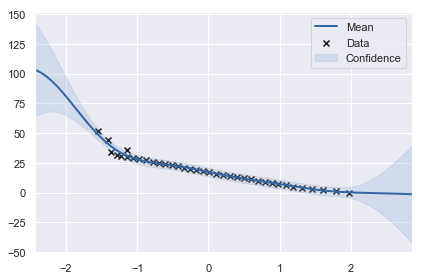

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


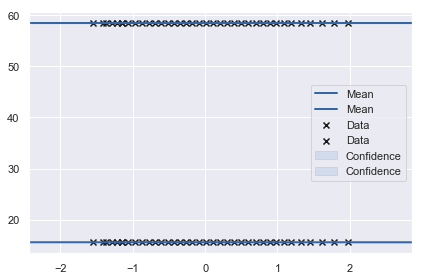

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


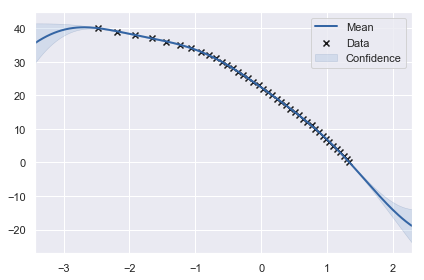

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


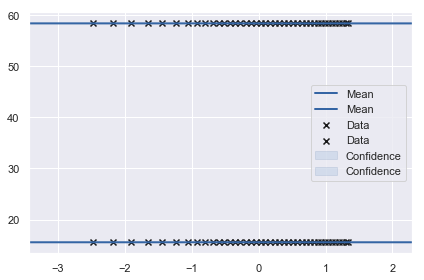

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


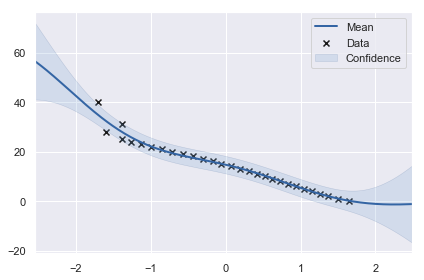

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


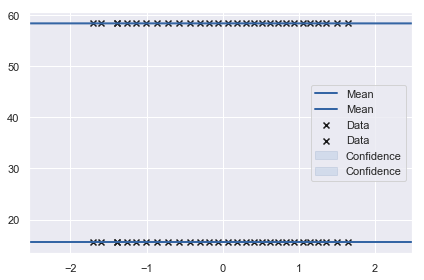

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


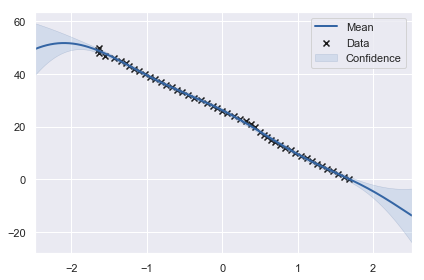

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


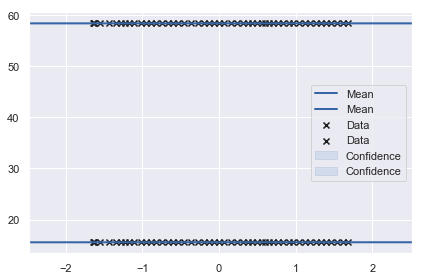

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


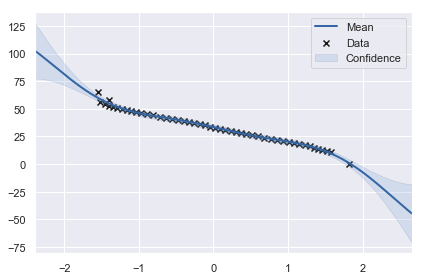

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


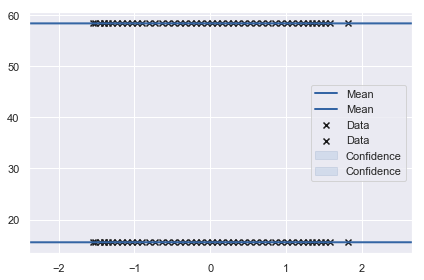

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


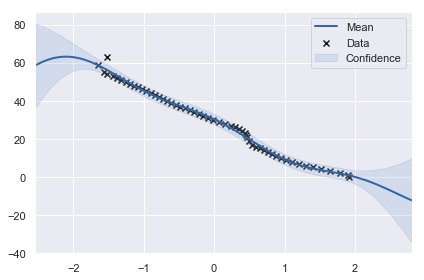

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


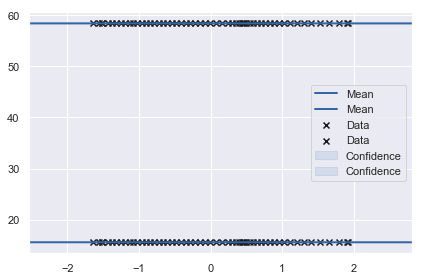

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


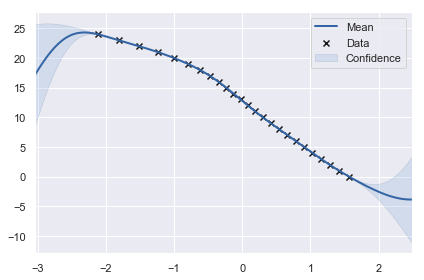

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


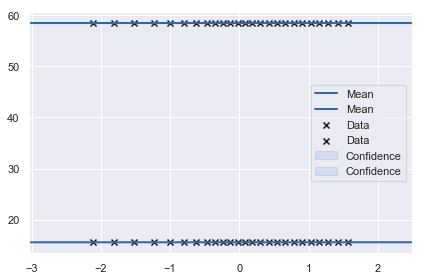

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


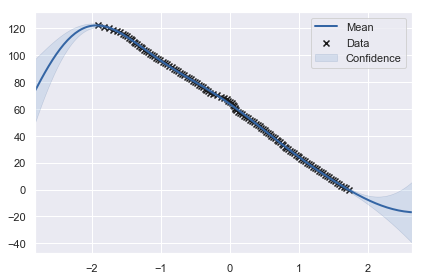

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


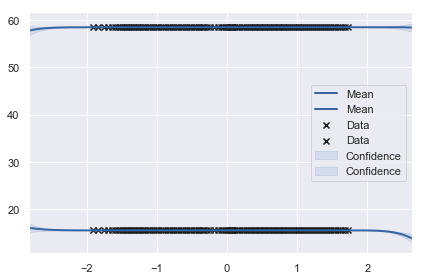

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


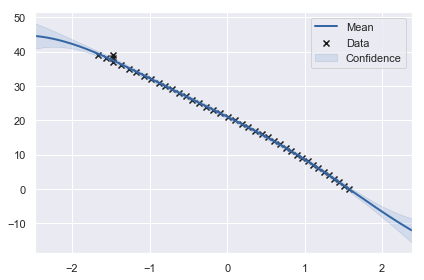

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


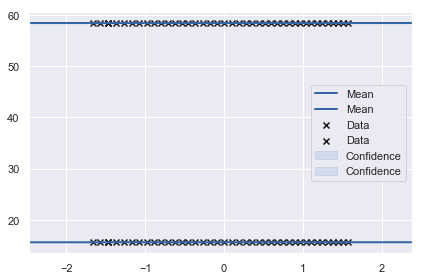

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


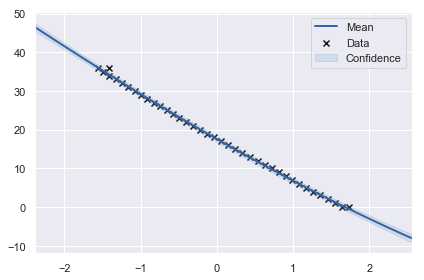

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


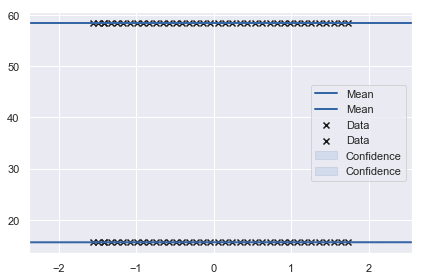

In [3]:
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    gp.plot(pred_model)
    gp.plot(lik_model)

The results for the prediction plots look really good, but the ones for the likelihood is a bit harder to interpret. We'll save both do disk though.

In [4]:
for models in traj_gps.values():
    for lik_model, pred_model in models.values():
        gp.save(lik_model)
        gp.save(pred_model)

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

            lat        lon  traj  seg  speed  time_left  progress
1612  15.555891  58.409981   4.0    4  12.70       23.0  0.000000
1613  15.555837  58.409760   4.0    4  -1.00       23.0  0.041667
1614  15.555867  58.409874   4.0    4  12.60       22.0  0.083333
1615  15.555837  58.409760   4.0    4  12.44       21.0  0.125000
1616  15.555816  58.409653   4.0    4  12.19       20.0  0.166667
1617  15.555791  58.409546   4.0    4  11.83       19.0  0.208333
1617
lat          15.555791
lon          58.409546
traj          4.000000
seg           4.000000
speed        11.830000
time_left    19.000000
progress      0.208333
tau           0.919968
Name: 1617, dtype: float64
(10.564393524937259, 0.002000514826642927)


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


-8.435606475062741

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


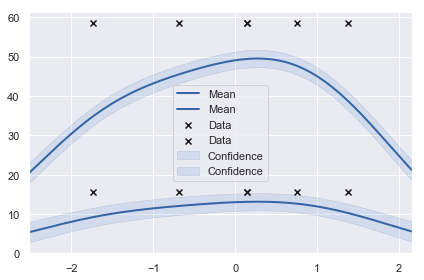

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


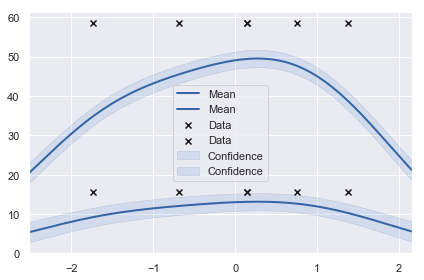

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


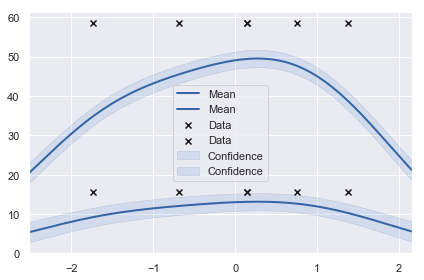

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


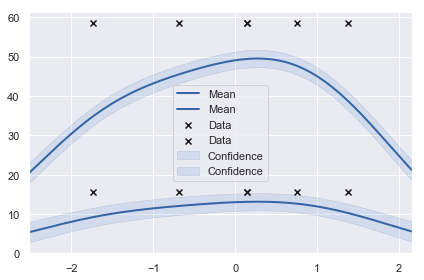

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


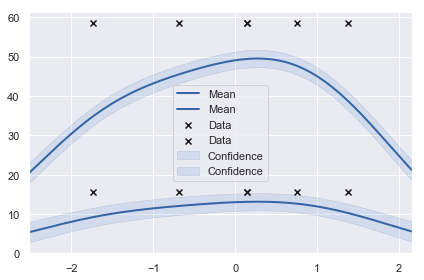

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


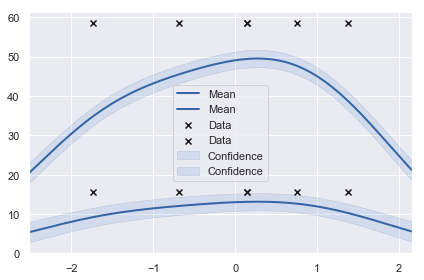

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


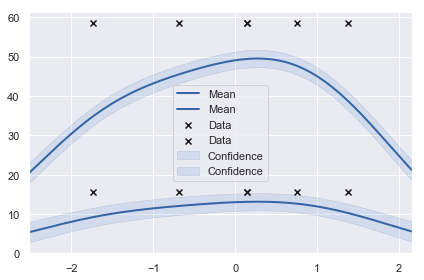

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


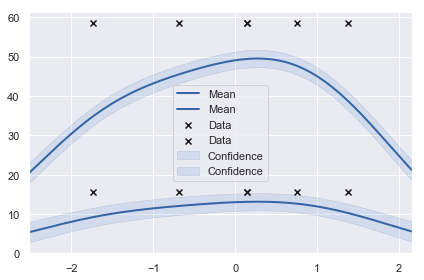

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


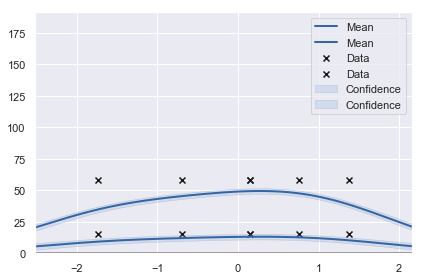

In [19]:
def mogp(traj, synch_gp, route_n, seg_n):

    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(1, 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)

    def models_by_likelihood(synched_traj, models):
        def mk_model(m): 
            model = gp.build(synched_traj, ['tau'], ['lat', 'lon'], '', m.route_n, m.traj_n, m.seg_n)
            gp.plot(model)
            return gp.set_params(model, m.model.param_array)

        models_with_this_traj = [mk_model(m) for m in models]
        sorted_models = sorted(models_with_this_traj, key=gp.loglik, reverse=True)
        max_loglik = np.max([gp.loglik(m) for m in sorted_models])
        return [(m, np.exp(gp.loglik(m) - max_loglik)) for m in sorted_models]

    synched_traj = synch_data(synch_gp, traj)
    latest_data_point = synched_traj.iloc[-1]
    print(latest_data_point)
    models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = models_by_likelihood(synched_traj, models)
    pred_models_with_weights = [(corresponding_pred_model(m), w) for m, w in lik_models_with_weights]
    predictions_with_weights = [(make_prediction(m, latest_data_point), w) for m, w in pred_models_with_weights]
    weighted_predictions = [(float(p[0]), float(p[1])/w) for p, w in predictions_with_weights] 
    for mean, sigma in weighted_predictions:
        x = np.random.normal(mean, sigma, size=50)
        sns.kdeplot(x)
            
    return weighted_predictions

test = pd.read_pickle('test.pkl')
n_test_trajs = test.traj.unique()
n_test_trajs = test.traj.unique()
n_test_segs = test.seg.unique()

def predict(traj, synch_gp, route_n, seg_n, plot=False):
    mixture = mogp(traj, synch_gp, route_n, seg_n)
    print(mixture[1])
    if plot:
        ax = sns.kdeplot(np.random.normal(mixture[0][0], mixture[0][1], size=50))
        for mean, sigma in mixture[1:]:
            x = np.random.normal(mean, sigma, size=50)
            sns.kdeplot(x, ax=ax)

    most_confident_model = sorted(mixture, key=lambda p: p[1])[0]
    prediction = most_confident_model[0]
    return prediction

np.random.seed(1)
test_traj = test[test.traj == n_test_trajs[0]]
seg_n = test_traj.seg.unique()[2]
test_seg = test_traj[test_traj.seg == seg_n]
i = np.random.randint(test_seg.index[0], test_seg.index[-1])
test_seg = test_seg[test_seg.index <= i]
print(test_seg)
print(i)
synch_gp = gp.load_synch(route_n, seg_n)
pred = predict(test_seg, synch_gp, route_n, seg_n, plot=True)
true = test_seg.iloc[-1].time_left
pred-true

# LÅT STÅ OS
#for traj_n in n_test_trajs:
#    traj = test[test.traj == traj_n]
#    n_traj_segs = traj.seg.unique()
#    for seg_n in n_traj_segs[0:1]:
#        seg = traj[traj.seg == seg_n]
#        i = np.random.randint(seg.index[0], seg.index[-1])
#       seg = seg[seg.index < i]
#        synch_gp = gp.load_synch(route_n, seg_n)
 #       predict(seg, synch_gp, route_n, seg_n)